In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import math
import gc
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from skorch.helper import predefined_split

isGoogleDrive = False
shouldImputeData = True
shouldRestoreImputer = True
isUsingCNN = True
if isGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    workingDirectory = r'E:\Google Drive\University 17215286\Honours\Semester 1\COS 711 Artificial Intelligence II\Assignments\Assignment 3\Code'
    os.getcwd()
    os.chdir(workingDirectory)
    os.getcwd()
    train=pd.read_csv("./data/Train.csv")
    test_no_labels=pd.read_csv("./data/Test.csv")
    metadata_station=pd.read_csv("./data/airqo_metadata.csv")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier
torch.manual_seed(7)

In [3]:
if isGoogleDrive:
    train = pd.read_csv("/content/drive/My Drive/COS 711 Assignment 3/data/Train.csv")
    test_no_labels = pd.read_csv("/content/drive/My Drive/COS 711 Assignment 3/data/Test.csv")
    metadata_station=pd.read_csv("./data/airqo_metadata.csv")

In [4]:
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [5]:
# covert features from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test_no_labels[feature]=test_no_labels[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

In [6]:
train = train.drop(columns=['ID']) #no need for ID column
test_no_labels = test_no_labels.drop(columns=['ID']) #no need for ID column

## Segment the data to have a separate test set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_actual, test_actual = train_test_split(train, test_size=0.15, random_state=7) #default random shuffle
train = train_actual

In [9]:
print(train.shape)
print(test_actual.shape)

(13208, 8)
(2331, 8)


# Processing the training data
### Visualisation of missing data
The following cell plots some random examples of missing data given a feature_index and num_to_select

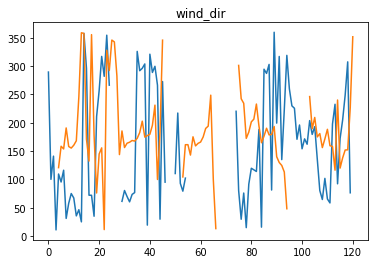

In [10]:
import random
feature_index =3
num_to_select = 2
list_vals = []
for index, row in train.iterrows():
    currFeature = row[features[feature_index]]
    if num_to_select == 0:
        break
    if(pd.Series(currFeature).isna().sum() > 0):
        if random.random() < 0.5:
            num_to_select -= 1
            list_vals.append(currFeature)
        
for l in list_vals:
    plt.plot(l)
plt.title(features[feature_index])
plt.show()

In [11]:
def dropRowsWithAnyNulls(df):
    for index, row in tqdm(df.iterrows()):
        for feature in features:
            if(pd.Series(row[feature]).isna().sum() > 0):
                df.drop(index, inplace= True, axis=0)
                break

### Creating a copy of the data set for Autoencoder imputation

In [12]:
if shouldImputeData:
    train_copy = train.copy() 

Remove nulls and generate training data for the autoencoder

In [13]:
if shouldImputeData:
    print(train_copy.shape)
    dropRowsWithAnyNulls(train_copy)
    print(train_copy.shape)

20it [00:00, 192.37it/s]

(13208, 8)


13208it [00:42, 312.56it/s]

(6125, 8)


In [14]:
class AutoencoderImputer(nn.Module):
    def __init__(self, inputDim):
        super(AutoencoderImputer, self).__init__()
        
        self.inputDim = inputDim
        self.h1Dim = int(inputDim * (2 / 3))
        self.h2Dim = int(inputDim * (1 / 3))
        self.h3Dim = self.h1Dim
        
        self.bn1 = nn.BatchNorm1d(self.h1Dim)
        self.bn2 = nn.BatchNorm1d(self.h2Dim)
        self.bn3 = nn.BatchNorm1d(self.h3Dim)
        self.ln1 = nn.Linear(inputDim, self.h1Dim)
        self.ln2 = nn.Linear(self.h1Dim, self.h2Dim) 
        self.ln3 = nn.Linear(self.h2Dim, self.h3Dim) 
        self.ln4 = nn.Linear(self.h3Dim, self.inputDim) 

    def forward(self, t):
        t = F.relu(self.bn1(self.ln1(t)))
        t = F.relu(self.bn2(self.ln2(t)))
        t = F.relu(self.bn3(self.ln3(t)))
        t = F.relu(self.ln4(t))
        return t

#### Utility functions

In [15]:
def convertRowToFlatTensor(row):
    tens = torch.tensor([])
    for feature in features:
        tens = torch.cat((tens, torch.tensor(row[feature])), -1)
    return tens

def convertNullsToConst(tens):
    tens[tens != tens] = -1
    return tens

#### Dataset 

In [16]:
class ImputeDataset(Dataset):
    #The initialisation of this dataset generates the inputs using random nulls
    def __init__(self, trainingDataframe, testDataframe=None):
        tmp = []
        for index, row in trainingDataframe.iterrows():
            tens = convertRowToFlatTensor(row)
            tmp.append(tens)
            
        self.targets = tmp #targets are the non null tensors
        self.data = self.getNullifiedData(self.targets)
        if testDataframe is not None:
            self.augmentWithTestData(testDataframe)
        print("Initiated Dataset\n")
    
    def getNullifiedData(self, listOfCompleteTargets):
        inputList = []
        for example in listOfCompleteTargets:
            inputList.append(self.generateRandomNulls(example))
        return inputList
         
    def generateRandomNulls(self, example):
        totalNullsAdded = 0
        targetTensor = example.clone()
        numTimes = random.randint(1, 4)
        while numTimes > 0:
            indexToStartNulls = random.randint(0, 120) 
            numNullsToAdd = random.randint(1, 20)  
            while numNullsToAdd > 0 and indexToStartNulls < 121:
                for i in range(len(features)):
                    targetTensor[indexToStartNulls + i * 121] = -1
                numNullsToAdd -= 1
                indexToStartNulls += 1
            numTimes -= 1    
        return targetTensor
    
    def augmentWithTestData(self, dataframe):
        dropRowsWithAnyNulls(dataframe)
        tmp = []
        for index, row in dataframe.iterrows():
            tens = convertRowToFlatTensor(row)
            tmp.append(tens)
        nullified = self.getNullifiedData(tmp)
        self.data.extend(nullified)
        self.targets.extend(tmp)        
            
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])
    
    def __len__(self):
        return len(self.data)

In [17]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    imputation_dataset = ImputeDataset(train_copy, test_no_labels) #preparing dataset with inputs containing random nulls and target outputss

In [18]:
from sklearn.datasets import make_regression
import skorch
from skorch import NeuralNet
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import cross_validate

autoencoder_regressor = NeuralNet(
    module=AutoencoderImputer,
    module__inputDim= 121*len(features),
    criterion=torch.nn.L1Loss,
    optimizer=torch.optim.Adam,
    max_epochs=1000,
    lr = 1e-3,
    device='cuda',
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5)]
)

In [19]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    autoencoder_regressor.fit(imputation_dataset)

#### Save the model

In [20]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    autoencoder_regressor.save_params(f_params='autoencoder_imputer2.pkl')

#### Load the model

In [21]:
if shouldRestoreImputer == True and shouldImputeData == True: 
    autoencoder_regressor.initialize()  # This is important!
    autoencoder_regressor.load_params(f_params='autoencoder_imputer2.pkl')

#### Illustrate an imputation example

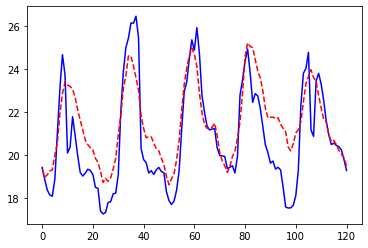

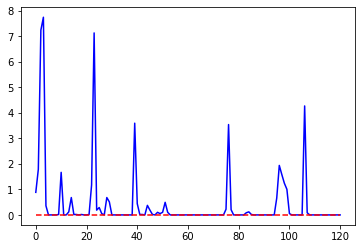

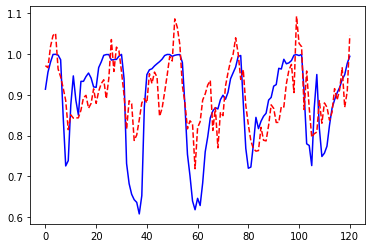

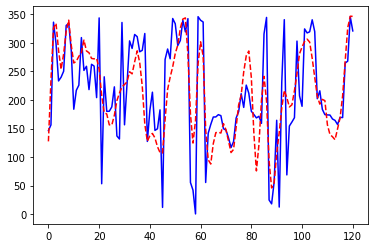

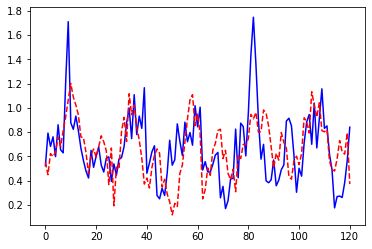

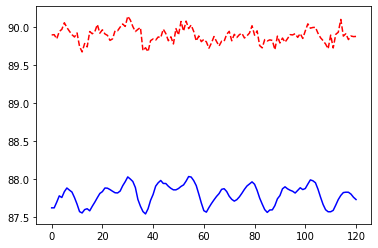

In [22]:
if shouldImputeData == True: 
    with torch.no_grad():
        inp = convertRowToFlatTensor(train.iloc[255])
        mask = inp != inp
        beforeNullsRemoved = inp.clone()
        inp = convertNullsToConst(inp)
        inp = torch.unsqueeze(inp, 0)
        res = autoencoder_regressor.predict(inp)
        res = res[0]
        toGraph = res
    #     for ind, truth in enumerate(mask):
    #         if truth:
    #             toGraph.append(res[ind])
    #         else:
    #             toGraph.append(np.nan)
        for i in range( int(len(beforeNullsRemoved) / 121)) :
            plt.plot(beforeNullsRemoved[(i * 121): ((i+1) * 121)], 'b-')
            plt.plot(toGraph[(i * 121): ((i+1) * 121)] , 'r--')
            plt.show()

### Filling in missing values
Use the autoencoder to fill in missing values

In [23]:
def shouldFillInMissingValues(row):
    for feature in features:
        sumOfNulls = pd.Series(row[feature]).isna().sum()
        if sumOfNulls > 60:
            return False
    return True

def getFeatureBucket(index):
    bucket =  int(index / 121) 
    for i in range(len(features)):
        if bucket == i:
            return features[i]
    return None

In [24]:
def imputeRow(row, model):
    inp = convertRowToFlatTensor(row)
    mask = inp != inp #find the nan values
    beforeNullsRemoved = inp.clone()
    inp = convertNullsToConst(inp)
    inp = torch.unsqueeze(inp, 0)
#     print(inp.shape)
    res = model.predict(inp)
    res = res[0]
    toGraph = []
    for ind, truth in enumerate(mask):
        if truth:
            featureBucket = getFeatureBucket(ind)
            index = ind % 121
            row[featureBucket][index] = res[ind]


In [25]:
if shouldImputeData == True: 
    r = train.iloc[0]
    print(r)
    imputeRow(r, autoencoder_regressor)
    # print()
    # autoencoder_regressor.predict(torch.rand(1,726))
    print(r)

location                                                        D
temp            [20.16666667, 20.44166667, 21.81666667, 22.7, ...
precip          [0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
rel_humidity    [0.913583333, 0.942416667, 0.917416667, 0.9047...
wind_dir        [289.5198562, 100.1314824, 141.0828999, 10.858...
wind_spd        [0.525833333, 0.61, 1.100833333, 0.860833333, ...
atmos_press     [90.575, 90.6325, 90.66916667, 90.695, 90.6108...
target                                                     42.694
Name: 13400, dtype: object
location                                                        D
temp            [20.16666667, 20.44166667, 21.81666667, 22.7, ...
precip          [0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
rel_humidity    [0.913583333, 0.942416667, 0.917416667, 0.9047...
wind_dir        [289.5198562, 100.1314824, 141.0828999, 10.858...
wind_spd        [0.525833333, 0.61, 1.100833333, 0.860833333, ...
atmos_press     [90.575, 90.6325, 90.66916667, 90

In [26]:
def imputeOnData(df, model):
    for index, row in tqdm(df.iterrows()):
        for feature in features:
            if(pd.Series(row[feature]).isna().sum() > 0):
                if shouldFillInMissingValues(row):
#                     print(row.head())
                    imputeRow(row, model)
#                     print(row.head())
                else:
#                     print('dropping row')
                    df.drop(index, inplace= True, axis=0)
                break

In [27]:
print(train.shape)
print(test_actual.shape)

(13208, 8)
(2331, 8)


In [28]:
if shouldImputeData == True: 
    imputeOnData(train, autoencoder_regressor)
    imputeOnData(test_actual, autoencoder_regressor)
else:
    dropRowsWithAnyNulls(train)
    dropRowsWithAnyNulls(test_actual)

13208it [01:16, 173.25it/s]
2331it [00:12, 181.98it/s]


In [29]:
print(train.shape)
print(test_actual.shape)

(12289, 8)
(2190, 8)


### Scaling data
The following functions help apply transforms the timeseries columns. The test dataset is scaled only based on the training dataset to prevent information leakage of test data into the training data

In [30]:
def convertSeriesofListsToDataFrame(series):
    listToConv = []
    for item in series:
        listToConv.append(item)
    newDF = pd.DataFrame(listToConv )
    return newDF

class CustomMinMaxScaler():
    def __init__(self, minVal, maxVal, feature_range=(-1, 1)):
        self.a = feature_range[0]
        self.b = feature_range[1]
        self.A = minVal
        self.B = maxVal
        self.scale_ = (self.b-self.a) / (self.B - self.A)
        
    def fit(self, data):
        return
    
    def transform(self,df):
        df -= self.A
        df *= self.scale_
        df += self.a
        return df.to_numpy()
    
class CustomStandardScaler():
    def __init__(self):
        self.mean = -1 #init
        self.std = -1
        
    def fit(self, dataframe, isTraining=True):
        if isTraining:
            self.mean = dataframe.stack().mean()
            self.std = dataframe.stack().std()
        return
    
    def transform(self, df):
        df -= self.mean
        df /= self.std
        return df.to_numpy() 
        
def scaleDataFrame(scaler, df, isTraining=True):
    if isTraining:
        scaler.fit(df) #the scalers are fit according to the training set and not the test set
    return scaler.transform(df)

def applyScaleTransformations(trainDataframe, infoDict, testDataframe):
    for key, value in infoDict.items():
        scaleResTrain = scaleDataFrame(value, convertSeriesofListsToDataFrame(trainDataframe[key]))
        scaleResTest = scaleDataFrame(value, convertSeriesofListsToDataFrame(testDataframe[key]), False)
        trainDataframe.drop(columns=[key])
        testDataframe.drop(columns=[key])

        seriesTrain = pd.Series(scaleResTrain.tolist())
        kwargs = {key : seriesTrain.values}
        trainDataframe = trainDataframe.assign(**kwargs)
        
        seriesTest = pd.Series(scaleResTest.tolist())
        kwargs = {key : seriesTest.values}
        testDataframe = testDataframe.assign(**kwargs)
        
    return trainDataframe, testDataframe

In [31]:
train.head()

,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
13400,D,"[20.16666667, 20.44166667, 21.81666667, 22.7, ...","[0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.913583333, 0.942416667, 0.917416667, 0.9047...","[289.5198562, 100.1314824, 141.0828999, 10.858...","[0.525833333, 0.61, 1.100833333, 0.860833333, ...","[90.575, 90.6325, 90.66916667, 90.695, 90.6108...",42.694043
14406,E,"[23.68333333, 24.51666667, 24.325, 23.41666667...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.787083333, 0.80075, 0.817333333, 0.85566666...","[159.4940113, 115.14581499999998, 298.3011528,...","[0.720833333, 0.7975, 0.415, 1.561666667, 2.02...","[88.31166667, 88.33666667, 88.28083333, 88.272...",20.941667
1740,B,"[21.88333333, 21.49166667, 21.35, 21.46666667,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7925, 0.788333333, 0.779166667, 0.783333333...","[185.1598778, 179.0868879, 174.41672069999996,...","[1.198333333, 1.464166667, 1.6791666669999998,...","[88.64, 88.685, 88.72333333, 88.75166667, 88.7...",106.118293
10598,C,"[18.61666667, 18.55, 18.55833333, 18.34166667,...","[0.034, 0.034, 0.0, 0.017, 0.017, 0.0, 0.068, ...","[0.995666667, 0.999, 0.999833333, 0.99975, 0.9...","[305.9133537, 301.9505753, 287.8784468, 268.63...","[0.901666667, 0.8091666670000001, 0.625833333,...","[87.69083333, 87.72833333, 87.8, 87.845, 87.87...",90.960889
9310,A,"[24.40833333, 23.31666667, 23.18333333, 22.325...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7180833329999999, 0.793333333, 0.786166667,...","[15.16579205, 201.5625559, 140.0581756, 113.17...","[0.470833333, 0.533333333, 0.770833333, 0.4775...","[88.40166667, 88.43333333, 88.45166667, 88.465...",76.324118


In [32]:
scalesToDo =  { 'wind_dir': CustomMinMaxScaler(0, 360),'temp' : CustomStandardScaler(), 'precip' : CustomStandardScaler()
              ,'wind_spd' : CustomStandardScaler(), 'atmos_press' : CustomStandardScaler(), 'rel_humidity' : CustomMinMaxScaler(0,1)
              }
train, test_actual = applyScaleTransformations(train, scalesToDo, test_actual)

In [33]:
train.head()

,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
13400,D,"[-0.7459874368773107, -0.6677518768267242, -0....","[-0.11892713286637936, 0.015706564562155616, -...","[0.8271666660000001, 0.8848333340000001, 0.834...","[0.6084436455555555, -0.4437139866666666, -0.2...","[-0.7334265513173749, -0.6054407582145671, 0.1...","[1.2933833631700689, 1.3434890542923548, 1.375...",42.694043
14406,E,"[0.2544794200547865, 0.49155687665015413, 0.43...","[-0.11892713286637936, -0.11892713286637936, -...","[0.574166666, 0.6014999999999999, 0.634666666,...","[-0.11392215944444439, -0.36030102777777784, 0...","[-0.43690501203570736, -0.32032389352065593, -...","[-0.6788928236086124, -0.6571077405119577, -0....",20.941667
1740,B,"[-0.25760788209450974, -0.36903428390630133, -...","[-0.11892713286637936, -0.11892713286637936, -...","[0.585, 0.5766666659999999, 0.5583333340000001...","[0.028665987777777735, -0.005072845000000048, ...","[0.2891926033847863, 0.693424959231236, 1.0203...","[-0.39278206851061853, -0.35356891893664766, -...",106.118293
10598,C,"[-1.1869515026169826, -1.2059176999411922, -1....","[-0.09444827878846392, -0.09444827878846392, -...","[0.9913333339999999, 0.998, 0.999666666, 0.999...","[0.6995186316666668, 0.6775031961111113, 0.599...","[-0.16192563485049752, -0.3025832880994936, -0...","[-1.2198890596514265, -1.1872114350064569, -1....",90.960889
9310,A,"[0.46073680564269787, 0.15016534188395697, 0.1...","[-0.11892713286637936, -0.11892713286637936, -...","[0.43616666599999987, 0.586666666, 0.572333334...","[-0.9157455997222222, 0.11979197722222223, -0....","[-0.8170608316275888, -0.7220218767296186, -0....","[-0.6004665244606706, -0.5728720916809373, -0....",76.324118


## Deal with the location metadata

In [34]:
# train_A = train[train['location'] == 'A']
# train_B = train[train['location'] == 'B']
# train_C = train[train['location'] == 'C']
# train_D = train[train['location'] == 'D']
# train_E = train[train['location'] == 'E']

In [35]:
# train_C.head()

NameError: name 'train_C' is not defined

In [ ]:
NUM_ITEMS = 121
has_integrity = True
for col in train_A:
    if col != 'location' and col != 'target':
        for cell in train_A[col]:
            if len(cell) != 121:
                has_integrity = False
                break 
if has_integrity:
    print("All cells have the correct length")
else:
    print('Warning! cells are not of the same length')

## Convert data to be suitable for LSTM
One row contains 121 steps through time for each of the 6 series.
Need to loop through the rows, and for each row convert it to the suitable format

In [36]:
#one row makes one input pattern.
def transform_df_to_lstm_format(dataframe):
    dfCollection = []
    dfCollectionTargets = []
    for i, row in dataframe.iterrows():
        df = pd.DataFrame()
        for indicator in features:
            col = row[indicator]
            df[indicator] = col #make the row now a column in a dataframe
        dfCollection.append(df)
        dfCollectionTargets.append(row['target'])
    return dfCollection, dfCollectionTargets


## Make a Dataloader

In [37]:
class WeatherDataset(Dataset):
    def __init__(self, trainingDataframes, targets):
        tmp = []
        for i in range(len(trainingDataframes)):
            tmp.append(torch.as_tensor(trainingDataframes[i].to_numpy()).float())
        self.data = tmp
        self.targets = torch.tensor(targets).float()
        print("Initiated Dataset\n")
        
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])
    
    def __len__(self):
        return len(self.data)
    
    def transpose_internals(self):
        for i, tens in enumerate(self.data):
            self.data[i] = torch.unsqueeze(tens.t(),0)
#         print(self.data[0])
#         print(self.data[0].t().shape)

#### Callback used to reset the hidden state

In [38]:
import pprint
class HiddenStateResetter(skorch.callbacks.Callback):
    def on_batch_begin(self, net, **kwargs):
        net.module_.reset_hidden_state()
        
class EarlyStoppingWaiter(skorch.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.isDone = False
    def on_epoch_end(self, net, dataset_train, dataset_valid):
        if self.isDone:
            return

        if net.history[-1, 'epoch'] > 100:
            net.set_params(callbacks__EarlyStopping__patience=10)
            self.isDone = True
            print("Done Waiting")
        

### Split the data into train and validation

In [39]:
train_input_lstm_format, train_target_lstm_format = transform_df_to_lstm_format(train)
weather_dataset = WeatherDataset(train_input_lstm_format, train_target_lstm_format)
if isUsingCNN:
    weather_dataset.transpose_internals()
train_size = int(0.85 * len(weather_dataset))
validation_size = len(weather_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(weather_dataset, [train_size, validation_size])

Initiated Dataset



# PyTorch LSTM Model
input.size() is (batch_size, seq_len, num_features)
Hidden will have (1, batch_size, hidden_size)

## Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, inputDim, hiddenDim, seqLength, numLayers, batch_size, bidirection=False):
        super(LSTMModel, self).__init__()
        
        self.inputDim = inputDim
        self.hiddenDim = hiddenDim
        self.seqLength = seqLength #sequence length will be 121 because those are the time steps
        self.numLayers = numLayers
        self.batch_size = batch_size
        
        if bidirection:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
            
        self.internalState = self.get_initial_hidden_state(batch_size) #cell state and hidden state
        
        self.lstm = nn.LSTM(input_size=inputDim, hidden_size=hiddenDim, num_layers=numLayers, batch_first= True)
        self.linear = nn.Linear(hiddenDim, 1) #output is a single real number value
        
    def forward(self, t):
        t, hn_cn = self.lstm(t, self.internalState)
#         self.internalState = self.detach_hidden_states(hn_cn) #detach from the graph 
        self.internalState = hn_cn
        output = self.linear(t)
        lastOutputsInSequences = output[:,-1]
        return lastOutputsInSequences.squeeze(1)
#         return output
    
    def get_initial_hidden_state(self, batch_size):
        return (torch.randn(self.numLayers*self.bidirectional, batch_size, self.hiddenDim).float().cuda(), torch.randn(self.numLayers*self.bidirectional, batch_size, self.hiddenDim).float().cuda()) #initial hidden state
    
    def reset_hidden_state(self):
        self.internalState = self.get_initial_hidden_state(self.batch_size)
    
    def detach_hidden_states(self, hidden):
        if isinstance(hidden, torch.Tensor):
            return hidden.detach()
        else:
            return tuple(self.detach_hidden_states(v) for v in hidden) 

#### Toy feed in the model to test dimensionality
Can uncomment the summary writer code for tensorboard

In [ ]:
# testModel = LSTMModel(inputDim = 6, hiddenDim = 100, seqLength = 121, numLayers = 1, batch_size=2).cuda()
# inp = torch.unsqueeze(torch.as_tensor(train_dataseta[0].to_numpy()), 0).float()
# inp2 = torch.unsqueeze(torch.as_tensor(train_dataset[62].to_numpy()), 0).float()
# res = torch.cat((inp,inp2), 0)
# r = testModel(Variable(res).cuda())
# print(r)
# print(testModel)

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/lstm_visualiser')
# writer.add_graph(testModel, (Variable(res).cuda()))
# writer.close()

## Hyperparameters

In [ ]:
from itertools import product
#define a dictionary of hyper parameters to test
parameters = dict(
    lr = [ 0.001],
    batch_size = [32],
    num_layers = [2]
    )
param_values = [v for v in parameters.values()]
#     print(f"l {lr} b {batch_size} n {num_layers}")

In [ ]:

experimentList = []
for learnRate, batchSize, numLayers in product(*param_values):
    for run in range(5):
        lstmModel = NeuralNet(
            module=LSTMModel,
            module__inputDim = 6,
            module__hiddenDim = 121,
            module__seqLength = 121,
            module__numLayers = numLayers,
            module__batch_size=batchSize,
            batch_size=batchSize,
            criterion=torch.nn.L1Loss,
            optimizer=torch.optim.Adam,
            max_epochs=500,
            lr = learnRate,
            device='cuda',
            iterator_train__shuffle=True,
            iterator_train__drop_last=True,
            iterator_valid__drop_last=True,
            train_split=predefined_split(validation_dataset),
             callbacks=[
                HiddenStateResetter(),
                EarlyStoppingWaiter(),
                EarlyStopping(patience=100)
            ]
        )
        lstmModel.fit(train_dataset)
        l = lstmModel.history[:, 'train_loss']
        v = lstmModel.history[:, 'valid_loss']
        experimentList.append({f"run_imputed_{run}-l_{learnRate} b_{batchSize} n_{numLayers}" : {'train' : l, 'val' : v} })
        lstmModel.save_params(f_params=f"run_imputed_{run}-l_{learnRate}-b_{batchSize}-n_{numLayers}.pkl")
        torch.cuda.empty_cache()


In [ ]:
# print(experimentList[0]['l_0.0001 b_16 n_1'])
for el in experimentList:
    for k in el:
#         print(k)
#         print(el[k]['val'])
        ind = k
        k = k[2:]
        k = 'L:' + k
#         k = k[:-3]
        k = k.replace('b_', 'B:')
        k = k.replace('n_', 'N:')
        k = k[-3:]
        plt.plot(el[ind]['val'][:150], label = k)
# plt.axvline(x=100, color='k', linestyle='--', label='Early Stopping')
plt.legend()
plt.ylabel('Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.show()

In [ ]:
import pickle
with open('runs_lstm_imputed_no_metadata.pkl', 'wb') as f:
    pickle.dump(experimentList, f)

In [ ]:
# with open('runs_layer2_no_metadata.pkl', 'rb') as f:
#     mynewlist = pickle.load(f)
#     print(mynewlist)

## Inference

In [179]:
test_actual_in_lstm, test_actual_target_lstm_format = transform_df_to_lstm_format(test_actual)
test_dataset = WeatherDataset(test_actual_in_lstm, test_actual_target_lstm_format)
if isUsingCNN:
    test_dataset.transpose_internals()

Initiated Dataset



In [175]:
from pandas.core.common import flatten
def evaluate_performance(models, trainDataset, validationDataset, testDataset):
#     in_data, targets = transform_df_to_lstm_format(test_actual[test_actual['location'] == 'A'])
#     weather_dataset = WeatherDataset(in_data, targets)
    data_loader_train = torch.utils.data.DataLoader(trainDataset, batch_size=32, num_workers=0, drop_last=True)
    data_loader_val = torch.utils.data.DataLoader(validationDataset, batch_size=32, num_workers=0, drop_last=True)
    data_loader_test = torch.utils.data.DataLoader(testDataset, batch_size=32, num_workers=0, drop_last=True)

    results = {}
    for i, model in enumerate(models):
        results[f'{i}'] = {}
#         model.eval()
        with torch.no_grad():
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_train):
                pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['trainRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
            
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_val):
                pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['valRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
            
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_test):
                pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['testRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
    return results
# Plotting
#             flat_targets = torch.flatten(targets).cpu()
#             flat_predicted = torch.flatten(predicted).cpu()
#             plt.plot(flat_targets, label='Targets',linestyle="",marker="o")
#             plt.plot(flat_predicted, label='Predicted',linestyle="",marker="x")
#             for i, val in enumerate(flat_predicted):
#                 plt.plot((i,i),(val,flat_targets[i]) ,c='black')
#             plt.legend()
#             plt.show()
#             return flat_predicted, flat_targets


In [ ]:
        
path = 'result_models/lstm_imputed_nometa/'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)):
        files.append(os.path.join(path,i)) 
loadedModels = []
for file in files:
    lstmModel = NeuralNet(
                module=LSTMModel,
                module__inputDim = 6,
                module__hiddenDim = 121,
                module__seqLength = 121,
                module__numLayers = numLayers,
                module__batch_size=batchSize,
                batch_size=batchSize,
                criterion=torch.nn.L1Loss,
                optimizer=torch.optim.Adam,
                max_epochs=500,
                lr = learnRate,
                device='cuda',
                iterator_train__shuffle=True,
                iterator_train__drop_last=True,
                iterator_valid__drop_last=True,
                train_split=predefined_split(validation_dataset),
                 callbacks=[
                    HiddenStateResetter(),
                    EarlyStoppingWaiter(),
                    EarlyStopping(patience=100)
                ]
            )    
    lstmModel.initialize()  # This is important!
    lstmModel.load_params(f_params=file)
    loadedModels.append(lstmModel)

results = evaluate_performance(loadedModels, train_dataset, validation_dataset, test_dataset)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# trainRes = []
# valRes = []
# testRes []
trainRMSE = []
valRMSE = []
testRMSE = []
trainMAE = []
valMAE = []
testMAE = []
for modelNum in results:
    trainRMSE.append(mean_squared_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valRMSE.append(mean_squared_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testRMSE.append(mean_squared_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
    trainMAE.append(mean_absolute_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valMAE.append(mean_absolute_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testMAE.append(mean_absolute_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
trainRMSE = np.sqrt(trainRMSE)
print(trainRMSE)
valRMSE = np.sqrt(valRMSE)
testRMSE = np.sqrt(testRMSE)
print("RMSE")
print("TrainRes: ", np.round(np.mean(trainRMSE), 2), " +- ", np.round(np.std(trainRMSE),2))
print("ValRes: ", np.round(np.mean(valRMSE), 2), " +- ", np.round(np.std(valRMSE),2))
print("TestRes: ", np.round(np.mean(testRMSE), 2), " +- ", np.round(np.std(testRMSE),2))
print("MAE")
print("TrainRes: ", np.round(np.mean(trainMAE), 2), " +- ", np.round(np.std(trainMAE),2))
print("ValRes: ", np.round(np.mean(valMAE), 2), " +- ", np.round(np.std(valMAE),2))
print("TestRes: ", np.round(np.mean(testMAE), 2), " +- ", np.round(np.std(testMAE),2))

# 
# r_square = r2_score(targetlist, predlist)

In [ ]:
predlist, targetlist = evaluate_performance(model)

# print(predlist)
# print(targetlist)
plt.bar([i for i, x in enumerate(predlist) ],abs(predlist-targetlist))
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

In [ ]:
l = lstmModel.history[:, 'train_loss']
v = lstmModel.history[:, 'valid_loss']
plt.clf()
plt.plot([i for i in range(len(l))], l, label='Train loss')
plt.plot([i for i in range(len(v))], v,  label='Valid loss')
plt.legend()
plt.show()

# Convolutional Neural Network

In [150]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, kernel_size, outChan):
        super(TimeSeriesCNN, self).__init__()
        self.magicNumber = 48
        self.outChan = outChan
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=outChan, kernel_size=kernel_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1,2))
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(outChan*self.magicNumber, 1)
#         self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, t):
        t = self.relu1(self.conv1(t)) 
        t = self.pool1(t)
#         print(t.shape)
        t = t.view(-1, self.outChan*self.magicNumber)
        t = self.fc1(t)
        t = self.relu2(t)
        return t.view(-1)


In [152]:
batch_size = 100
channels = 1
height = 6
length = 121
kernel_size = (height, 25)

cnn = TimeSeriesCNN(kernel_size, 200)
# train_dataset[0][0].shape
x = torch.randn(batch_size, channels, height, length)
cnn(x)
# print(x.shape)
# print(torch.unsqueeze(x, 1).shape)
# res = cnn(x)
# print(res)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0255, 0.0000, 0.0000, 0.0786,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0243, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0458,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1859, 0.2168, 0.0000, 0.1133, 0.0000, 0.0000, 0.3016, 0.0000, 0.0974,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1208, 0.3030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1739, 0.0000, 0.0000, 0.0279, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0472, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1806, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3868], grad_fn=<ViewBackward>)

In [172]:
experimentList = []

In [173]:
from skorch.helper import predefined_split
outChannelList = [1024]
for outChan in outChannelList:
    for run in range(5):
        cnnModel = NeuralNet(
                    module=TimeSeriesCNN,
                    module__kernel_size = (height, 25),
                    module__outChan = outChan,
                    batch_size=32,
                    criterion=torch.nn.L1Loss,
                    optimizer=torch.optim.Adam,
                    max_epochs=500,
                    lr = 0.0001,
                    device='cuda',
                    iterator_train__shuffle=True,
                    iterator_train__drop_last=True,
                    iterator_valid__drop_last=True,
                    train_split=predefined_split(validation_dataset),
                     callbacks=[
            #                     EarlyStoppingWaiter(),
                        EarlyStopping(patience=10)
                    ]
            )
        cnnModel.fit(train_dataset)
        l = cnnModel.history[:, 'train_loss']
        v = cnnModel.history[:, 'valid_loss']
        experimentList.append({f"run_cnn_loss_imputed_fmap{outChan}_run{run}" : {'train' : l, 'val' : v} })
        cnnModel.save_params(f_params=f"run_cnn_imputed_exp_run{run}.pkl")

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       25.7762       24.3606  2.1233
      2       22.6316       23.4686  2.1493
      3       22.0765       23.0571  2.2993
      4       21.7465       22.8538  2.2023
      5       21.4557       22.5306  2.1433
      6       21.2073       22.3425  2.1553
      7       20.9786       22.5201  2.7911
      8       20.7803       21.9679  2.1213
      9       20.5277       21.9636  2.1073
     10       20.3041       21.7365  2.1043
     11       20.1111       21.6132  2.1063
     12       19.9548       21.4902  2.1053
     13       19.7588       21.3692  2.0733
     14       19.5340       21.3613  2.0773
     15       19.4430       21.2265  2.0893
     16       19.3239       21.2302  2.0913
     17       19.1544       20.9488  2.0923
     18       18.9912       20.9111  2.0883
     19       18.8376       20.9635  2.0873
     20       18.7307       20.8004  2.0823
     21       18.6220       20.7

    144       10.1481       17.5424  2.0953
    145       10.1228       17.4988  2.0883
    146       10.0171       17.4552  2.1013
    147       10.0331       17.4516  2.0953
    148        9.9709       17.4606  2.1033
    149        9.9334       17.6096  2.1083
    150        9.9425       17.4495  2.1173
    151        9.7887       17.4221  2.1183
    152        9.8225       17.5842  2.1293
    153        9.7488       17.3961  2.1183
    154        9.7114       17.5403  2.0813
    155        9.7112       17.3855  2.0753
    156        9.6654       17.3736  2.0773
    157        9.6043       17.3430  2.0883
    158        9.6794       17.3735  2.0873
    159        9.5166       17.4549  2.1033
    160        9.4734       17.4616  2.1353
    161        9.5414       17.4314  2.1003
    162        9.3568       17.3918  2.1133
    163        9.3433       17.3038  2.1043
    164        9.2538       17.3668  2.8921
    165        9.3313       17.4140  2.0743
    166        9.2385       17.3

    115       11.5413       17.8893  2.0633
    116       11.5292       17.7442  2.0493
    117       11.4318       17.7879  2.0444
    118       11.3635       17.7672  2.0423
    119       11.3396       17.9510  2.0583
    120       11.2772       17.7921  2.0523
    121       11.1341       17.7155  2.0464
    122       11.2046       17.6966  2.0533
    123       11.1520       17.6830  2.0433
    124       11.0717       17.7660  2.0563
    125       10.9828       17.6917  2.0474
    126       10.9940       17.6227  2.0573
    127       10.9245       17.6852  2.0464
    128       10.9009       17.6340  2.0533
    129       10.8913       17.5730  2.0573
    130       10.8330       17.7241  2.0643
    131       10.7138       17.6727  2.0393
    132       10.6690       17.6497  2.0574
    133       10.6291       17.5543  2.0503
    134       10.6176       17.6570  2.0534
    135       10.5752       17.5546  2.0863
    136       10.4810       17.6387  2.0730
    137       10.5111       17.5

     32       17.4472       20.1923  2.0434
     33       17.4108       20.0222  2.0603
     34       17.2729       19.8117  2.0504
     35       17.1631       19.8511  2.0443
     36       17.0696       19.8149  2.0444
     37       16.9387       19.7380  2.0463
     38       16.9315       19.6560  2.0393
     39       16.7944       19.6469  2.0603
     40       16.7259       19.6148  2.0443
     41       16.5887       19.4821  2.0433
     42       16.4863       19.6562  2.0504
     43       16.4669       19.3905  2.0463
     44       16.3338       19.6970  2.0424
     45       16.2602       19.4863  2.0463
     46       16.2228       19.3925  2.0473
     47       16.0963       19.2898  2.0463
     48       15.9832       19.2728  2.0464
     49       15.8877       19.1217  2.0484
     50       15.8164       19.2355  2.0574
     51       15.7336       19.0373  2.0533
     52       15.5986       19.0615  2.0563
     53       15.5366       19.0726  2.0463
     54       15.5228       18.9

     27       17.9248       20.3838  2.7191
     28       17.8305       20.3006  2.0933
     29       17.7087       20.1432  2.0433
     30       17.6471       20.2039  2.0394
     31       17.5136       20.0438  2.0573
     32       17.4341       19.8911  2.0414
     33       17.3161       19.9610  2.0433
     34       17.2112       19.8487  2.0493
     35       17.1621       19.9964  2.0473
     36       17.0950       20.0633  2.0464
     37       16.9474       19.6833  2.0443
     38       16.8423       19.6492  2.0434
     39       16.7858       19.7520  2.0483
     40       16.6714       19.5407  2.0403
     41       16.5863       19.8235  2.0433
     42       16.5027       19.5153  2.0574
     43       16.3347       19.4784  2.0553
     44       16.2910       19.4843  2.0554
     45       16.2093       19.3678  2.0343
     46       16.1636       19.3724  2.0573
     47       16.0968       19.3017  2.0493
     48       15.9725       19.3659  2.0573
     49       15.9214       19.2

    175        8.9438       17.2519  2.0533
    176        8.8654       17.2726  2.0593
    177        8.9730       17.2745  2.0564
    178        8.8506       17.3031  2.1283
    179        8.7619       17.1615  2.0563
    180        8.7903       17.1701  2.0583
    181        8.6921       17.2176  2.0573
    182        8.6350       17.2119  2.4412
    183        8.6452       17.3183  2.0414
    184        8.6150       17.2008  2.0733
    185        8.6034       17.1698  2.0523
    186        8.5119       17.2774  2.0653
    187        8.4875       17.4150  2.0523
    188        8.4176       17.1962  2.0554
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       25.7167       24.2785  2.0703
      2       22.6103       23.3772  2.0623
      3       22.1316       23.0162  2.0723
      4       21.7494       22.8305  2.0613
      5       21.4789       22.6007  2.8081
      6   

    130       10.7716       17.5627  2.0474
    131       10.7351       17.7251  2.0583
    132       10.7057       17.5096  2.0533
    133       10.5829       17.5749  2.0514
    134       10.5880       17.5292  2.0513
    135       10.5604       17.5331  2.0633
    136       10.4876       17.6004  2.0533
    137       10.4455       17.5557  2.0603
    138       10.3782       17.6401  2.0543
    139       10.3660       17.4254  2.0483
    140       10.3306       17.4762  2.0523
    141       10.2255       17.4611  2.0523
    142       10.2098       17.4238  2.0513
    143       10.2210       17.5179  2.0493
    144       10.1210       17.4411  2.0534
    145       10.0616       17.4371  2.0564
    146       10.0304       17.3993  2.0523
    147       10.0015       17.3963  2.0513
    148        9.9628       17.4562  2.0863
    149        9.9323       17.3704  2.0693
    150        9.8626       17.4471  2.0693
    151        9.9132       17.4023  2.0613
    152        9.8255       17.3

In [140]:
l = cnnModel.history[:, 'train_loss']
v = cnnModel.history[:, 'valid_loss']
windowSize = 25
experimentList.append({f"run_cnn_loss_imputed_winSize{windowSize}" : {'train' : l, 'val' : v} })
cnnModel.save_params(f_params=f"run_cnn_imputed_window{windowSize}.pkl")


In [170]:
import pickle
with open('runs_cnn_imputed_fmaptest_experimentlist_no_metadata.pkl', 'wb') as f:
    pickle.dump(experimentList, f)

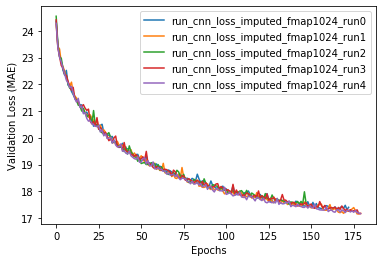

In [174]:
for el in experimentList:
    for k in el:
#         print(k)
#         print(el[k]['val'])
        ind = k
#         k = k.replace('run_cnn_loss_imputed_fmap', '')
#         k= 'Feature Maps: ' + k
#         k = 'L:' + k
# #         k = k[:-3]
#         k = k.replace('b_', 'B:')
#         k = k.replace('n_', 'N:')
#         k = k[-3:]
        plt.plot(el[ind]['val'][:180], label = k)
# plt.axvline(x=100, color='k', linestyle='--', label='Early Stopping')
plt.legend()
plt.ylabel('Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.show()

In [180]:
        
path = 'result_models/cnn_imputed_nometa/'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)):
        files.append(os.path.join(path,i)) 
loadedModels = []
for file in files:
    cnnModel = NeuralNet(
                    module=TimeSeriesCNN,
                    module__kernel_size = (height, 25),
                    module__outChan = outChan,
                    batch_size=32,
                    criterion=torch.nn.L1Loss,
                    optimizer=torch.optim.Adam,
                    max_epochs=500,
                    lr = 0.0001,
                    device='cuda',
                    iterator_train__shuffle=True,
                    iterator_train__drop_last=True,
                    iterator_valid__drop_last=True,
                    train_split=predefined_split(validation_dataset),
                     callbacks=[
            #                     EarlyStoppingWaiter(),
                        EarlyStopping(patience=10)
                    ]
            )   
    cnnModel.initialize()  # This is important!
    cnnModel.load_params(f_params=file)
    loadedModels.append(cnnModel)

results = evaluate_performance(loadedModels, train_dataset, validation_dataset, test_dataset)

In [181]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [182]:
# trainRes = []
# valRes = []
# testRes []
trainRMSE = []
valRMSE = []
testRMSE = []
trainMAE = []
valMAE = []
testMAE = []
for modelNum in results:
    trainRMSE.append(mean_squared_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valRMSE.append(mean_squared_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testRMSE.append(mean_squared_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
    trainMAE.append(mean_absolute_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valMAE.append(mean_absolute_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testMAE.append(mean_absolute_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
trainRMSE = np.sqrt(trainRMSE)
print(trainRMSE)
valRMSE = np.sqrt(valRMSE)
testRMSE = np.sqrt(testRMSE)
print("RMSE")
print("TrainRes: ", np.round(np.mean(trainRMSE), 2), " +- ", np.round(np.std(trainRMSE),2))
print("ValRes: ", np.round(np.mean(valRMSE), 2), " +- ", np.round(np.std(valRMSE),2))
print("TestRes: ", np.round(np.mean(testRMSE), 2), " +- ", np.round(np.std(testRMSE),2))
print("MAE")
print("TrainRes: ", np.round(np.mean(trainMAE), 2), " +- ", np.round(np.std(trainMAE),2))
print("ValRes: ", np.round(np.mean(valMAE), 2), " +- ", np.round(np.std(valMAE),2))
print("TestRes: ", np.round(np.mean(testMAE), 2), " +- ", np.round(np.std(testMAE),2))

# 
# r_square = r2_score(targetlist, predlist)

[21.359657 19.294395 23.252422 20.920353 19.807592]
RMSE
TrainRes:  20.93  +-  1.38
ValRes:  29.75  +-  0.55
TestRes:  27.24  +-  0.47
MAE
TrainRes:  8.37  +-  1.08
ValRes:  17.24  +-  0.22
TestRes:  16.17  +-  0.21


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from torch.utils.data.dataloader import default_collate

# class SliceDatasetX(Dataset):
#     """Helper class that wraps a torch dataset to make it work with sklearn"""
#     def __init__(self, dataset, collate_fn=default_collate):
#         self.dataset = dataset
#         self.collate_fn = collate_fn
#         self._indices = list(range(len(self.dataset)))
        
#     def __len__(self):
#         return len(self.dataset)
        
#     @property
#     def shape(self):
#         return len(self),
    
#     def __getitem__(self, i):
#         if isinstance(i, (int, np.integer)):
#             Xb = self.dataset[i][0]
#             return Xb
        
#         if isinstance(i, slice):
#             i = self._indices[i]

#         Xb = self.collate_fn([self.dataset[j][0] for j in i])
#         return Xb
    
# weather_dataset = WeatherDataset(dfCollection, dfCollectionTargets)
# y_from_ds = np.asarray([weather_dataset[i][1] for i in range(len(weather_dataset))])
# print(y_from_ds.shape)
# ds_sliceable = SliceDatasetX(weather_dataset)
# print(ds_sliceable.shape)
# print(y_from_ds[0])


In [ ]:
# params = {
#     'lr': [0.01, 0.02],
#     'max_epochs': [10, 20],
# #     'module__num_units': [10, 20],
# }

# gs = GridSearchCV(lstmModel, params, refit=False, cv=3, scoring='neg_mean_absolute_error')
# gs.fit(ds_sliceable, y_from_ds)
# print(gs.best_score_, gs.best_params_)


In [ ]:
# lstmModel.predict(weather_dataset.__getitem__(0))
# l = lstmModel.history[:, 'train_loss']
# v = lstmModel.history[:, 'valid_loss']
# print(v)
# plt.clf()
# plt.plot([i for i in range(len(l))], l, label='Train loss')
# plt.plot([i for i in range(len(v))], v,  label='Valid loss')
# plt.legend()
# plt.show()

## Training

In [ ]:
# batch_size = 32
# num_epochs = 500
# hidden_dimension = 121
# num_layers = 2 #todo add multiple layers with dropout
# lossesOverTime = []

In [ ]:
# weather_dataset = WeatherDataset(dfCollection, dfCollectionTargets)
# data_loader = torch.utils.data.DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
# model = LSTMModel(inputDim = 6, hiddenDim = hidden_dimension, seqLength = 121, numLayers = num_layers, batch_size=batch_size).cuda()
# # hiddenState = model.get_initial_hidden_state(batch_size=batch_size)

# loss_function = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# for epoch in tqdm(range(num_epochs)):
#     for i_batch, (x, y) in enumerate(data_loader):
#         x = Variable(x.float()).cuda()
#         y = Variable(y.float()).cuda()
# #         out, hiddenState = model(x, hiddenState)
#         model.reset_hidden_state() #batches are unrelated, and should have different states
#         out = model(x)
# #         hiddenState = repackage_hidden(hiddenState)        
#         model.zero_grad()
#         loss = loss_function(out, y)
#         if i_batch % 50 == 0: 
#             print(f"batch: {i_batch}, loss: {loss}\n predicted: {out} target: {y}")
#         lossesOverTime.append(loss.item())
#         loss.backward()
#         optimizer.step()

In [ ]:
# plt.plot(lossesOverTime)
# plt.show()

In [ ]:
# test_actual.head()